<a href="https://colab.research.google.com/github/p588/spark-foundation/blob/main/Group_7_Machine_Learning_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Sentiment analysis on hotel reviews

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import spacy
import nltk

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_csv('/content/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
df.shape


(20491, 2)

In [ ]:
df.isnull().sum()

Review    0
Rating    0
dtype: int64

In [ ]:
df["Rating"].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

In [ ]:
df.loc[df["Review"] == ""]

,Review,Rating


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
df.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [ ]:
pos = [5]
neg = [1, 2]
neu = [3, 4]

def sentiment(rating):
  if rating in pos:
    return 2
  elif rating in neg:
    return 0
  else:
    return 1
df['Sentiment'] = df['Rating'].apply(sentiment)
df.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,1
3,"unique, great stay, wonderful time hotel monac...",5,2
4,"great stay great stay, went seahawk game aweso...",5,2


In [ ]:
fig = go.Figure([go.Bar(x=df.Sentiment.value_counts().index, y=df.Sentiment.value_counts().tolist())])
fig.update_layout(title="Values in each Sentiment",xaxis_title="Sentiment",yaxis_title="Values")
fig.show()

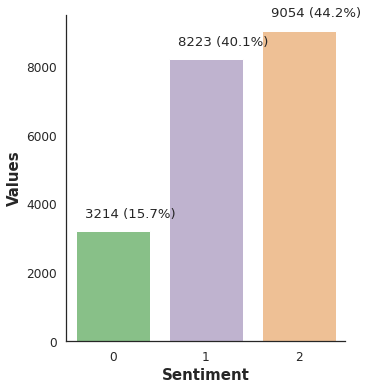

In [ ]:
sns.set(style='white',font_scale=1.1)
fig = plt.figure(figsize=[5,6])
ax = sns.countplot(data=df,x='Sentiment',palette='Accent')

for p in ax.patches:
        ax.annotate(str(p.get_height())+' ('+str((p.get_height()/len(df)*100).round(1))+'%)', (p.get_x()+0.1, p.get_height()+400))
plt.xlabel('Sentiment',weight='bold',fontsize='15')
plt.ylabel('Values',weight='bold',fontsize='15')
sns.despine()
plt.savefig('targetplot1.png',transparent=True, bbox_inches='tight')

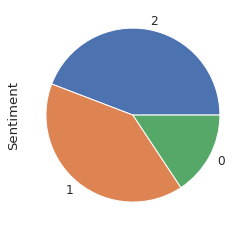

In [ ]:
df['Sentiment'].value_counts().head(10).plot.pie()
import matplotlib.pyplot as plt
plt.gca().set_aspect('equal')

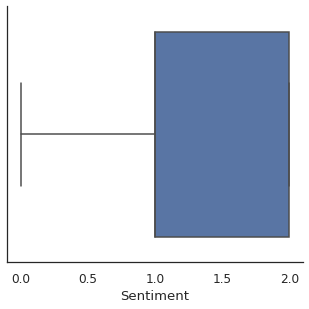

In [ ]:
with sns.axes_style('white'):
    sns.catplot(x="Sentiment", data=df, kind="box", height=4.5, aspect=1.0)
    plt.show()

In [ ]:
corr_matrix=df.corr()
corr_matrix

,Rating,Sentiment
Rating,1.000000,0.945373
Sentiment,0.945373,1.000000


In [ ]:
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words("english"))
punctuations = """!()-![]{};:,+'"\,<>./?@#$%^&*_~Â""" #List of punctuation to remove

def reviewParse(review):
    splitReview = review.split() #Split the review into words
    parsedReview = " ".join([word.translate(str.maketrans('', '', punctuations)) + " " for word in splitReview]) #Takes the stubborn punctuation out
    return parsedReview #Returns the parsed review

def clean_review(review):
    clean_words = []
    splitReview = review.split()
    for w in splitReview:
        if w.isalpha() and w not in stopwords_list:
            clean_words.append(w.lower())
    clean_review = " ".join(clean_words)
    return clean_review

df["Review"] = df["Review"].apply(reviewParse).apply(clean_review) #Parse all the reviews for their punctuation and add it into a new column

df.head() #Take a peek at the dataset

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms experience hotel monaco seattle goo...,3,1
3,unique great stay wonderful time hotel monaco ...,5,2
4,great stay great stay went seahawk game awesom...,5,2


In [ ]:
docs = list(df['Review'])[:4000]
print(docs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# settings that you use for count vectorizer will go here
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_features = 20000)

# just send in all your docs here
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docs)

In [ ]:
X = tfidf_vectorizer_vectors.toarray()
Y = df['Sentiment'][:4000]

In [ ]:
len(X[0])

20000

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier

SEED=123

X_train,X_test,y_train,y_test=train_test_split(X, Y, test_size=0.2, random_state=SEED, stratify=Y)

In [ ]:
fig = go.Figure([go.Bar(x=Y.value_counts().index, y=Y.value_counts().tolist())])
fig.update_layout(title="Values in each Sentiment",xaxis_title="Sentiment",yaxis_title="Values")
fig.show()

Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier(random_state=SEED)
dt.fit(X_train,y_train)
y_pred_test = dt.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,dt.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,dt.predict(X_test)),4)))


Training Accuracy score: 1.0
Testing Accuracy score: 0.52


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))


              precision    recall  f1-score   support

    positive       0.55      0.53      0.54       156
     neutral       0.50      0.48      0.49       333
    negative       0.53      0.56      0.54       311

    accuracy                           0.52       800
   macro avg       0.53      0.52      0.52       800
weighted avg       0.52      0.52      0.52       800



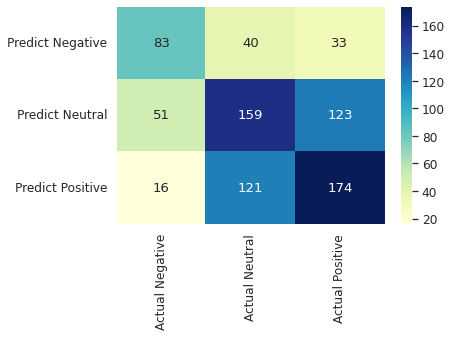

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'],
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

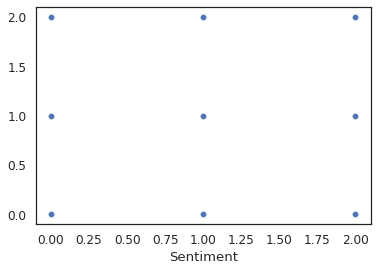

In [ ]:
sns.scatterplot(data= dt , x= y_test , y= y_pred_test)

Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,gnb.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,gnb.predict(X_test)),4)))


Training Accuracy score: 0.9169
Testing Accuracy score: 0.4625


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))


              precision    recall  f1-score   support

    positive       0.36      0.33      0.35       156
     neutral       0.47      0.55      0.51       333
    negative       0.51      0.43      0.47       311

    accuracy                           0.46       800
   macro avg       0.45      0.44      0.44       800
weighted avg       0.46      0.46      0.46       800



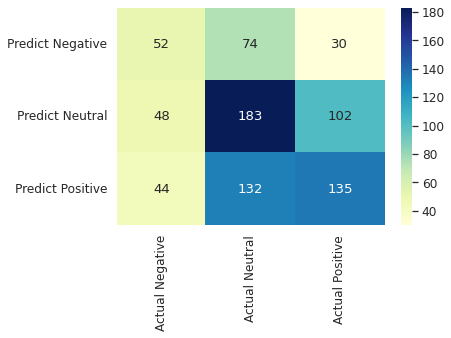

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'],
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=SEED).fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,lr.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,lr.predict(X_test)),4)))


Training Accuracy score: 0.92
Testing Accuracy score: 0.705


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))


              precision    recall  f1-score   support

    positive       0.86      0.69      0.77       156
     neutral       0.65      0.69      0.67       333
    negative       0.70      0.73      0.71       311

    accuracy                           0.70       800
   macro avg       0.74      0.70      0.72       800
weighted avg       0.71      0.70      0.71       800



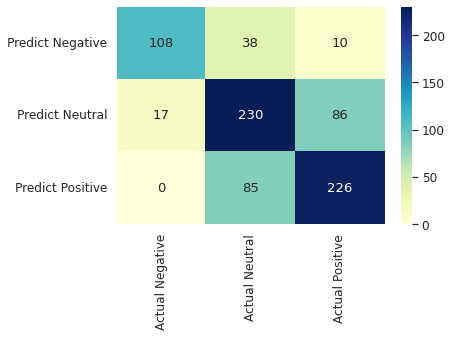

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'],
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

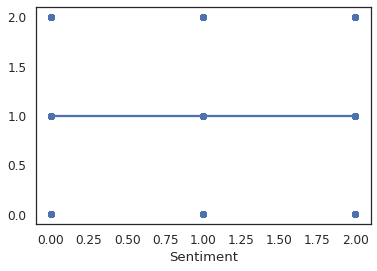

In [ ]:

sns.regplot(x=y_test, y=y_pred_test, data=df, logistic=True, ci=None)

Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,clf.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,clf.predict(X_test)),4)))


Training Accuracy score: 1.0
Testing Accuracy score: 0.6412


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))


              precision    recall  f1-score   support

    positive       0.89      0.45      0.60       156
     neutral       0.58      0.71      0.64       333
    negative       0.65      0.66      0.66       311

    accuracy                           0.64       800
   macro avg       0.71      0.61      0.63       800
weighted avg       0.67      0.64      0.64       800



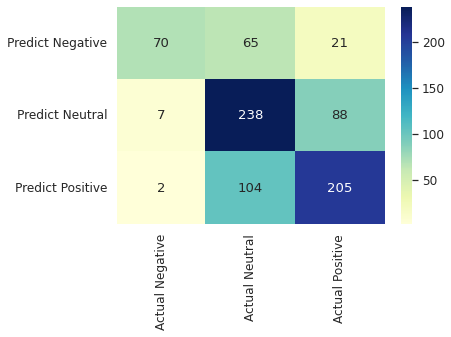

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'],
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

Text(0.5, 1.0, 'Random Forest Regression')

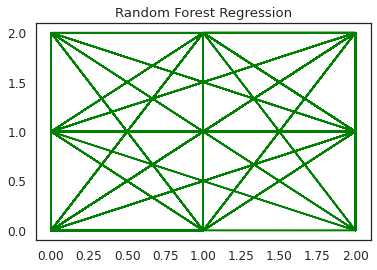

In [ ]:
plt.plot(y_test, y_pred_test,
         color = 'green')
plt.title('Random Forest Regression')

Ensembling

In [ ]:
from sklearn.ensemble import VotingClassifier

classifiers = [('Decision Tree', dt),('Logistic Regression', lr),('Naive Bayes', gnb)]
vc = VotingClassifier(estimators=classifiers)
# Fit 'vc' to the traing set and predict test set labels
vc.fit(X_train, y_train)

print("Training Accuracy score: "+str(round(accuracy_score(y_train,vc.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,vc.predict(X_test)),4)))


Training Accuracy score: 0.9919
Testing Accuracy score: 0.6225


In [ ]:
predictions = pd.Series(lr.predict(X), name="sentiment")
results = pd.concat([predictions],axis=1)
results.to_csv("sample-review-sentiment.csv",index=False)

In [ ]:
df=pd.read_csv('/content/sample-review-sentiment.csv')
df

,sentiment
0,1
1,0
2,1
3,2
4,2
...,...
3995,1
3996,1
3997,0
3998,2
